In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

# KNN Regression

### Warm-up 🥵

* How are weights implemented in K Nearest Neighbors when using the default in `sklearn` (aka the `'uniform'` option)?
* How are weights implemented in K Nearest Neighbors when using the `'distance'` option in `sklearn`?
  
* What type of supervised learning problem were we using KNN on up until now?

## Data Import and General EDA 🚗

We'll be looking at the auto MPG dataset from UCI.  Which can be found [here](https://archive.ics.uci.edu/ml/datasets/auto+mpg).  From the description we see:

```
1. mpg: continuous
2. cylinders: multi-valued discrete
3. displacement: continuous
4. horsepower: continuous
5. weight: continuous
6. acceleration: continuous
7. model year: multi-valued discrete
8. origin: multi-valued discrete
9. car name: string (unique for each instance)
```

Our target variable will be `mpg`.

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original"
names = [
    "mpg",
    "cylinders",
    "displacement",
    "horsepower",
    "weight",
    "acceleration",
    "year",
    "origin",
    "model",
]

# '\s+' means "more than 1 space" you can download the
# data from the data_url to inspect the data and see why this makes sense
auto = pd.read_csv(data_url, sep="\s+", names=names)
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,model
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino


<IPython.core.display.Javascript object>

Do some general eda.

In [21]:
auto.isna().mean()

mpg             0.0
cylinders       0.0
displacement    0.0
horsepower      0.0
weight          0.0
acceleration    0.0
year            0.0
origin          0.0
model           0.0
make            0.0
dtype: float64

<IPython.core.display.Javascript object>

In [4]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     406 non-null    float64
 2   displacement  406 non-null    float64
 3   horsepower    400 non-null    float64
 4   weight        406 non-null    float64
 5   acceleration  406 non-null    float64
 6   year          406 non-null    float64
 7   origin        406 non-null    float64
 8   model         406 non-null    object 
dtypes: float64(8), object(1)
memory usage: 28.7+ KB


<IPython.core.display.Javascript object>

In [5]:
auto.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
count,398.000000,406.000000,406.000000,400.000000,406.000000,406.000000,406.000000,406.000000
mean,23.514573,5.475369,194.779557,105.082500,2979.413793,15.519704,75.921182,1.568966
std,7.815984,1.712160,104.922458,38.768779,847.004328,2.803359,3.748737,0.797479
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,105.000000,75.750000,2226.500000,13.700000,73.000000,1.000000
50%,23.000000,4.000000,151.000000,95.000000,2822.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,302.000000,130.000000,3618.250000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


<IPython.core.display.Javascript object>

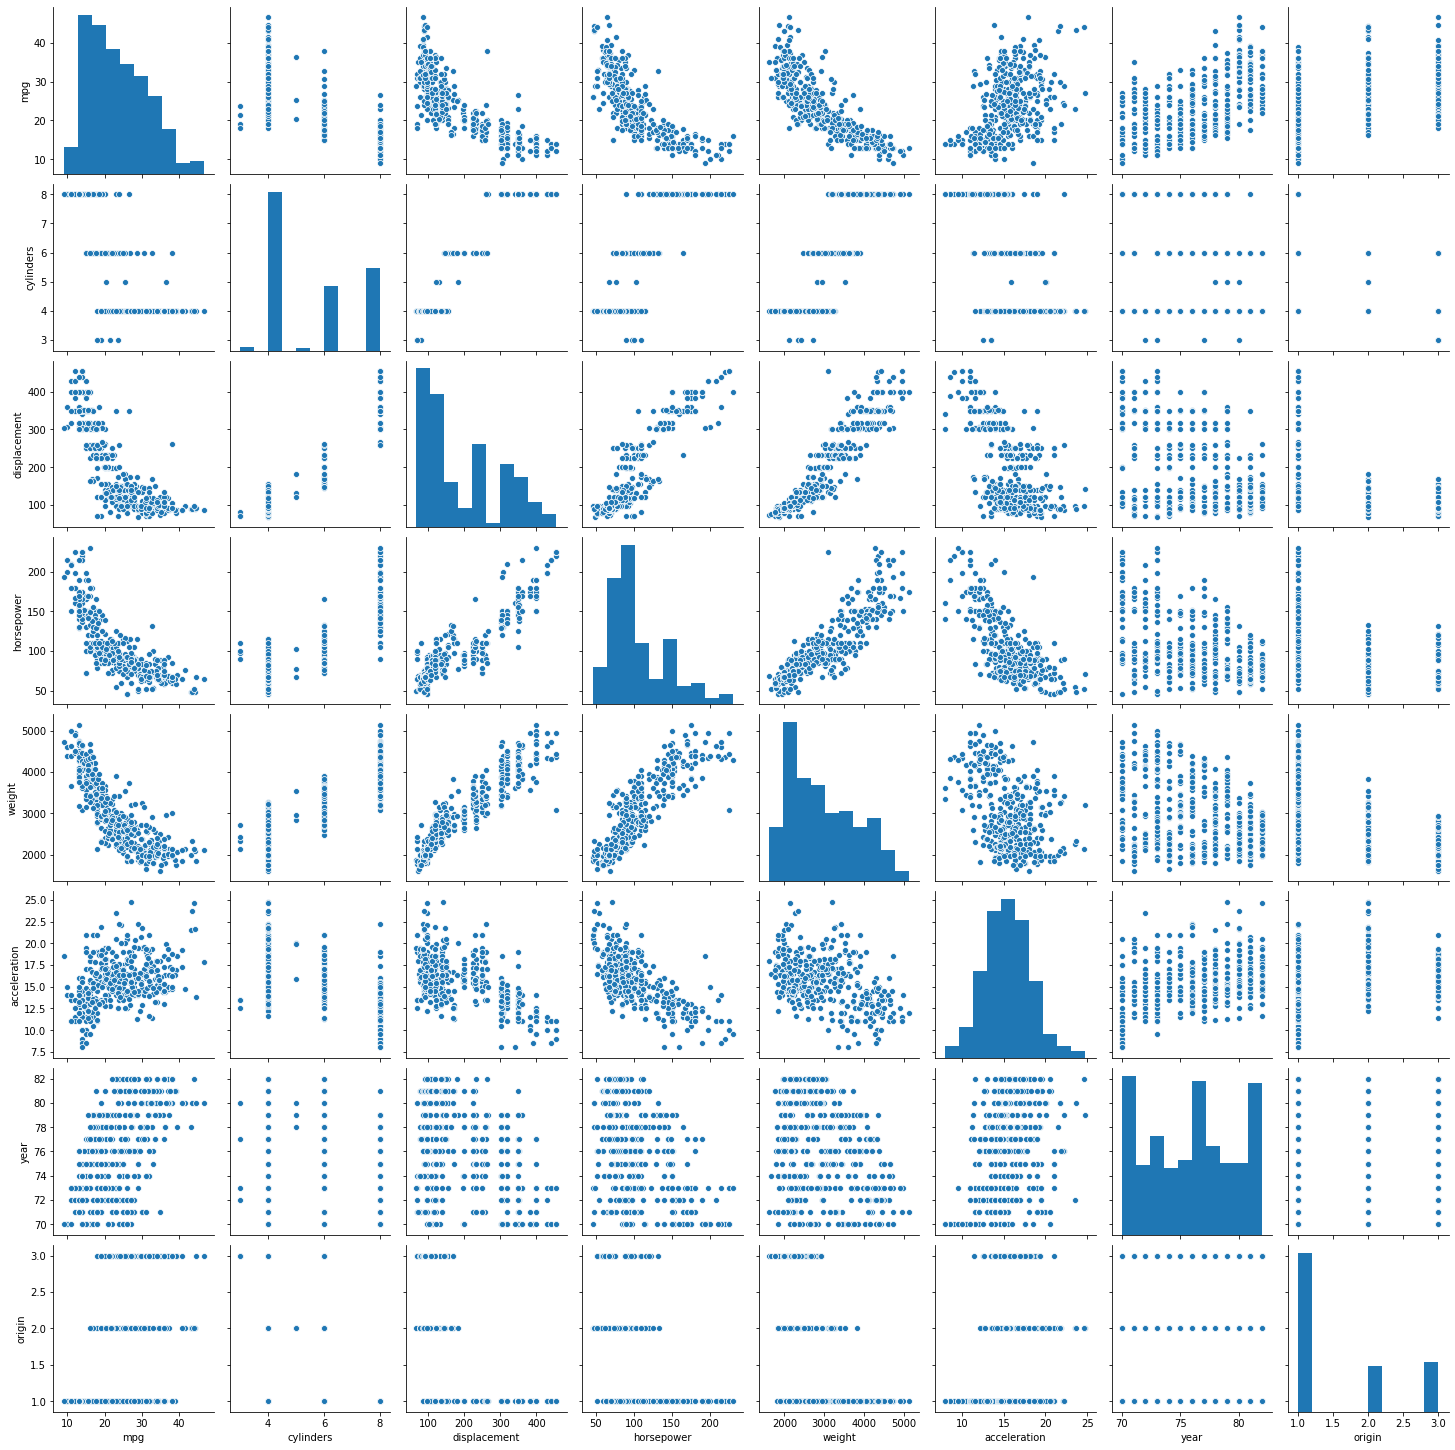

<IPython.core.display.Javascript object>

In [6]:
# sns.pairplot(auto)

Display rows with any NAs in them.

In [7]:
auto[auto.isna().any(axis=1)]

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,model
10,NaN,4.0,133.0,115.0,3090.0,17.5,70.0,2.0,citroen ds-21 pallas
11,NaN,8.0,350.0,165.0,4142.0,11.5,70.0,1.0,chevrolet chevelle concours (sw)
12,NaN,8.0,351.0,153.0,4034.0,11.0,70.0,1.0,ford torino (sw)
13,NaN,8.0,383.0,175.0,4166.0,10.5,70.0,1.0,plymouth satellite (sw)
14,NaN,8.0,360.0,175.0,3850.0,11.0,70.0,1.0,amc rebel sst (sw)
17,NaN,8.0,302.0,140.0,3353.0,8.0,70.0,1.0,ford mustang boss 302
38,25.0,4.0,98.0,NaN,2046.0,19.0,71.0,1.0,ford pinto
39,NaN,4.0,97.0,48.0,1978.0,20.0,71.0,2.0,volkswagen super beetle 117
133,21.0,6.0,200.0,NaN,2875.0,17.0,74.0,1.0,ford maverick
337,40.9,4.0,85.0,NaN,1835.0,17.3,80.0,2.0,renault lecar deluxe


<IPython.core.display.Javascript object>

In [8]:
auto.shape

(406, 9)

<IPython.core.display.Javascript object>

## Data Cleaning and Feature Engineering

### Handling NAs

Since our target variable is `mpg` we probably don't want to do any imputation strategy on it.  We should drop NAs in the target unless we have some domain expertise that tells us otherwise.

In [9]:
auto = auto.dropna(subset=["mpg"])

<IPython.core.display.Javascript object>

In [10]:
auto.shape

(398, 9)

<IPython.core.display.Javascript object>

The `horsepower` column is responsible for the rest of the NAs.  In practice, we might look up this info somehow, but that would probably take too much time for this demo.

So how do you want to handle these? by dropping? with imputation?  If imputing, what should we impute?

In [11]:
auto["horsepower"] = auto["horsepower"].fillna(auto["horsepower"].median())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>

### Handling Categorical Variables

* From the description of the columns above, we can see that `origin` should is a 'discrete' value.
* The `model` column is also a categorical variable
* You can also see that `year` is 'discrete' from the description, but in practice we'll treat year variables as ordinal, so we don't need to make any changes.

Show the value counts for each of our categorical columns (don't include year).  How do we want to handle each?

In [12]:
auto["origin"].value_counts()

1.0    249
3.0     79
2.0     70
Name: origin, dtype: int64

<IPython.core.display.Javascript object>

In [13]:
auto["model"].nunique()

305

<IPython.core.display.Javascript object>

The `model` column has perhaps too much variation.  Maybe we'd like to have less variation, how can we transform this variable to have a higher level categorical variable?

After making the transformation in mind, we still have some category levels with very little support (i.e. not a lot of observations to learn from).  Create an `'other'` category to hold these low occuring category levels.

In [14]:
auto["make"] = auto["model"].str.split(" ").str[0]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>

In [15]:
auto["make"].value_counts()

ford             51
chevrolet        43
plymouth         31
dodge            28
amc              28
toyota           25
datsun           23
buick            17
pontiac          16
volkswagen       15
honda            13
mercury          11
mazda            10
oldsmobile       10
peugeot           8
fiat              8
audi              7
chrysler          6
vw                6
volvo             6
renault           5
subaru            4
opel              4
saab              4
chevy             3
maxda             2
mercedes-benz     2
bmw               2
cadillac          2
triumph           1
vokswagen         1
hi                1
chevroelt         1
capri             1
nissan            1
mercedes          1
toyouta           1
Name: make, dtype: int64

<IPython.core.display.Javascript object>

In [16]:
make_counts = auto["make"].value_counts()
above_thresh_makes = make_counts[make_counts > 4]
keep_makes = above_thresh_makes.index

<IPython.core.display.Javascript object>

In [17]:
make_filter = auto["make"].isin(keep_makes)
auto.loc[-make_filter, "make"] = "other"
auto["make"].value_counts()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


ford          51
chevrolet     43
plymouth      31
other         31
amc           28
dodge         28
toyota        25
datsun        23
buick         17
pontiac       16
volkswagen    15
honda         13
mercury       11
oldsmobile    10
mazda         10
peugeot        8
fiat           8
audi           7
volvo          6
chrysler       6
vw             6
renault        5
Name: make, dtype: int64

<IPython.core.display.Javascript object>

In [18]:
# make_filter = auto["make"].isin(keep_makes)
# auto = auto[make_filter]

<IPython.core.display.Javascript object>

## Modeling

Perform a train/test split with 20% of the data in the test set.

In [31]:
X = auto.drop(columns=["mpg", "model", "displacement", "weight"])
y = auto["mpg"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

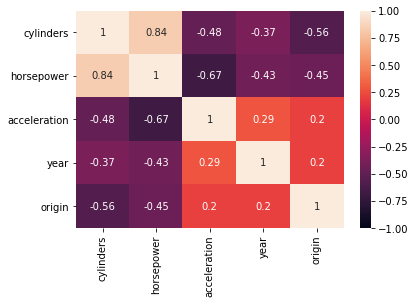

<IPython.core.display.Javascript object>

In [32]:
sns.heatmap(X_train.corr(), vmin=-1, vmax=1, annot=True)

We're going to build... a modeling pipeline for KNN.

In [23]:
X.head()

,cylinders,displacement,horsepower,weight,acceleration,year,origin,make
0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet
1,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick
2,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth
3,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc
4,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford


<IPython.core.display.Javascript object>

In [33]:
[c for c in X if c not in cat_cols]

['cylinders', 'horsepower', 'acceleration', 'year']

<IPython.core.display.Javascript object>

In [34]:
cat_cols = ["make", "origin"]  # What categorical columns do we have?
drop_cats = ["other", 1.0]  # Which categories from those columns do we want to drop?

# The rest are numeric
num_cols = [c for c in X if c not in cat_cols]

<IPython.core.display.Javascript object>

In [35]:
preprocessing = ColumnTransformer(
    [
        ("scale", StandardScaler(), num_cols),
        ("one_hot_encode", OneHotEncoder(drop=drop_cats), cat_cols),
    ]
)

<IPython.core.display.Javascript object>

In [36]:
pipeline = Pipeline(
    [
        # ("name of step", sklearn object with a fit method)
        ("preprocessing", preprocessing),
        ("knn", KNeighborsRegressor()),
    ]
)

<IPython.core.display.Javascript object>

In [37]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('scale',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['cylinders', 'horsepower',
                                                   'acceleration', 'year']),
                                                 ('one_hot_encode',
                                                  OneHotEncoder(categories='auto',
                                                                drop=['other',
                                                                      1.0],
  

<IPython.core.display.Javascript object>

How does the model perform?  What metric is being shown? What other metrics might we consider?

In [39]:
pipeline.score(X_train, y_train)

0.864233642763084

<IPython.core.display.Javascript object>

In [38]:
pipeline.score(X_test, y_test)

0.8763469454867936

<IPython.core.display.Javascript object>

In [41]:
y_pred = pipeline.predict(X_test)

resid = y_pred - y_test


0.08729660165591256

<IPython.core.display.Javascript object>

In [42]:
# MAE: on average we predict within 1.96 mpg of the right mpg
np.mean(np.abs((resid)))

1.95775

<IPython.core.display.Javascript object>

In [ ]:
# MAPE: on average we predict within 8.7% of the right mpg
np.mean(np.abs((resid / y_test)))

Text(0, 0.5, 'Predicted')

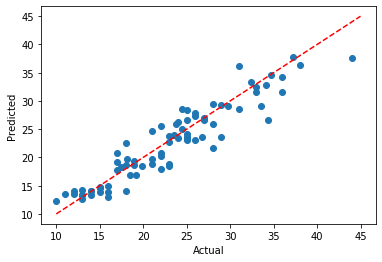

<IPython.core.display.Javascript object>

In [45]:
plt.scatter(y_test, y_pred)
plt.plot([10, 45], [10, 45], "--", c="red")
plt.xlabel("Actual")
plt.ylabel("Predicted")

Optimize the value of k in your pipeline.

In [50]:
grid = {
    "knn__n_neighbors": np.arange(1, 100, 5),
    "knn__weights": ["uniform", "distance"],
}

<IPython.core.display.Javascript object>

In [51]:
pipeline_cv = GridSearchCV(pipeline, grid, verbose=1, n_jobs=-1)
pipeline_cv.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.3s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('scale',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         ['cylinders',
                                                                        

<IPython.core.display.Javascript object>

What is the best value of k?

In [52]:
pipeline_cv.best_params_

{'knn__n_neighbors': 21, 'knn__weights': 'distance'}

<IPython.core.display.Javascript object>

How does the model perform?

In [53]:
train_score = pipeline_cv.score(X_train, y_train)
test_score = pipeline_cv.score(X_test, y_test)

print(f"train_score: {train_score}")
print(f"test_score: {test_score}")

train_score: 0.9998746075136313
test_score: 0.8608755154632207


<IPython.core.display.Javascript object>